In [24]:
import os
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

stage_name = "stage1"
model_dir = f"results/regime/{stage_name}/models"
data_dir = f"results/regime/{stage_name}/data"
figures_dir = f"results/regime/{stage_name}/figures"
save_figures = False

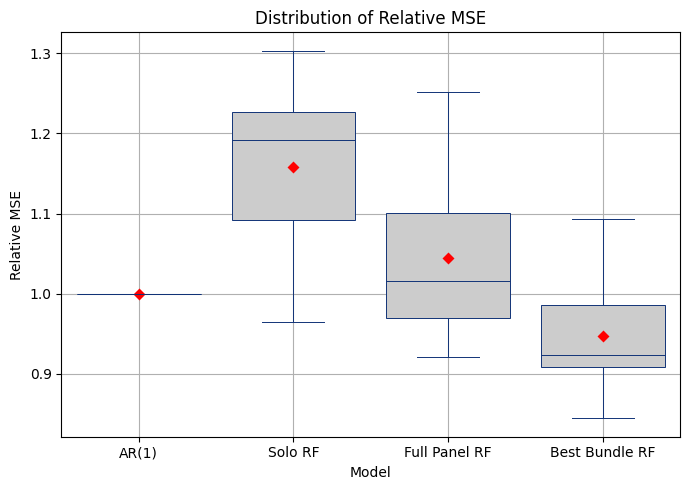

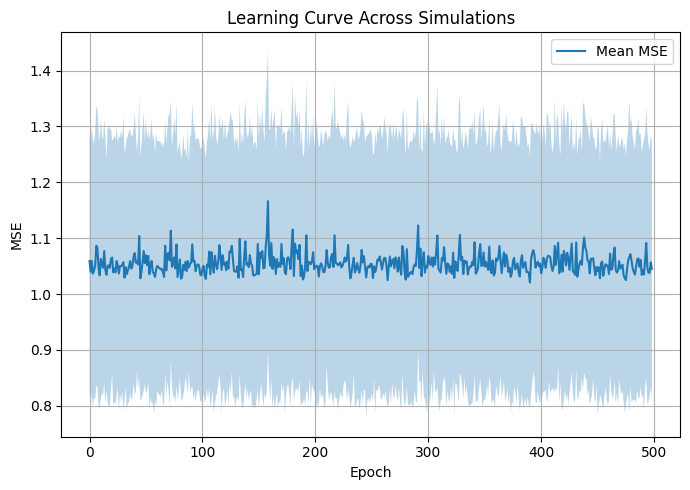

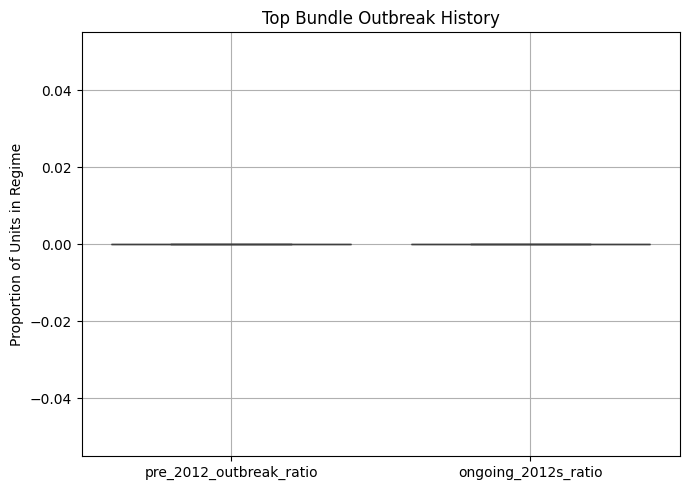

In [25]:
benchmark_records = []
bundle_records = []
learning_curves = []

for file in sorted(os.listdir(model_dir)):
    if not file.endswith(".pkl"):
        continue

    sim_id = int(file.split("_")[-1].split(".")[0])
    model_path = os.path.join(model_dir, file)
    data_path = os.path.join(data_dir, f"df_sim_{sim_id}.parquet")
    if not os.path.exists(model_path) or not os.path.exists(data_path):
        continue

    with open(model_path, "rb") as f:
        results = pickle.load(f)
    df = pd.read_parquet(data_path)
    df["period"] = pd.to_datetime(df["period"])

    # --- Relative MSE
    benchmarks = results["benchmarks"]
    ar1 = benchmarks["ar1_mse"]
    benchmark_records.append({
        "sim_id": sim_id,
        "AR(1)": 1.0,
        "Solo RF": benchmarks["solo_rf_mse"] / ar1,
        "Full Panel RF": benchmarks["full_panel_rf_mse"] / ar1,
        "Best Bundle RF": benchmarks["best_bundle_rf_mse"] / ar1,
    })

    # --- Bundle diagnostics
    bundle_units = results["top_bundles"][0][1]
    total = len(bundle_units)
    pre_2012 = 0
    during_2012s = 0

    for unit in bundle_units:
        d = df[df["unit"] == unit]
        
        if ((d["period"] < pd.Timestamp("2012-03-01")) & (d["delta"] == 1)).any():
            pre_2012 += 1
        
        if ((d["period"] >= pd.Timestamp("2012-03-01")) &
            (d["period"] <= pd.Timestamp("2018-12-01")) &
            (d["delta"] == 1)).any():
            during_2012s += 1

    bundle_records.append({
        "sim_id": sim_id,
        "bundle_size": total,
        "pre_2012_outbreak_ratio": pre_2012 / total if total > 0 else np.nan,
        "ongoing_2012s_ratio": during_2012s / total if total > 0 else np.nan
    })

    learning_curves.append(results["avg_mse_per_epoch"])

# --- Plot 1: Relative Benchmark Comparison
df_bench = pd.DataFrame(benchmark_records).melt(id_vars="sim_id", var_name="model", value_name="relative_mse")
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_bench, x="model", y="relative_mse", color=".8", linecolor="#137", linewidth=.7, showfliers=False)
sns.pointplot(data=df_bench, x="model", y="relative_mse",
              estimator="mean", color="red", markers="D",
              linestyles="none", err_kws={'linewidth': 0}, markersize=4)
plt.title("Distribution of Relative MSE")
plt.ylabel("Relative MSE")
plt.xlabel("Model")
plt.grid(True)
plt.tight_layout()
if save_figures:
    plt.savefig(os.path.join(figures_dir, f"sim_{stage_name}_boxplot.pdf"), format="pdf", bbox_inches="tight", dpi=300)
plt.show()

# --- Plot 2: Learning Curve
df_learn = pd.DataFrame(learning_curves)
plt.figure(figsize=(7, 5))
mean_curve = df_learn.mean()[:-1]
std_curve = df_learn.std()[:-1]
plt.plot(mean_curve.index, mean_curve.values, label="Mean MSE")
plt.fill_between(mean_curve.index, mean_curve - std_curve, mean_curve + std_curve, alpha=0.3)
plt.title("Learning Curve Across Simulations")
plt.xlabel("Epoch")
plt.ylabel("MSE")
plt.grid(True)
plt.legend()
plt.tight_layout()
if save_figures:
    plt.savefig(os.path.join(figures_dir, f"sim_{stage_name}_learning_curve.pdf"), format="pdf", bbox_inches="tight", dpi=300)
plt.show()

# --- Plot 3: Bundle History Diagnostics
df_bundle = pd.DataFrame(bundle_records)
plt.figure(figsize=(7, 5))
sns.boxplot(data=df_bundle[["pre_2012_outbreak_ratio", "ongoing_2012s_ratio"]])
plt.title("Top Bundle Outbreak History")
plt.ylabel("Proportion of Units in Regime")
plt.grid(True)
plt.tight_layout()
plt.show()

In [26]:
df_bench.groupby("model")["relative_mse"].describe().T

model,AR(1),Best Bundle RF,Full Panel RF,Solo RF
count,13.0,13.000000,13.000000,13.000000
mean,1.0,0.947432,1.044467,1.157704
std,0.0,0.064873,0.096060,0.103862
min,1.0,0.844161,0.920841,0.964939
25%,1.0,0.907980,0.969872,1.092094
50%,1.0,0.923363,1.015444,1.191382
75%,1.0,0.985949,1.101115,1.226349
max,1.0,1.093034,1.251746,1.303338


In [27]:
df_bundle.describe()

,sim_id,bundle_size,pre_2012_outbreak_ratio,ongoing_2012s_ratio
count,13.00000,13.00000,13.0,13.0
mean,6.00000,4.00000,0.0,0.0
std,3.89444,1.47196,0.0,0.0
min,0.00000,2.00000,0.0,0.0
25%,3.00000,3.00000,0.0,0.0
50%,6.00000,4.00000,0.0,0.0
75%,9.00000,5.00000,0.0,0.0
max,12.00000,6.00000,0.0,0.0


In [28]:
import os
import pickle
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def plot_extreme_donor_similarity(model_dir, data_dir, stage_name="stage2", 
                                  target_rho=0.8, target_gamma=1.4, sim_range=range(100), 
                                  save_figures=False, figures_dir="figures"):
    """
    Plots the parameter similarity of the most and least included donors across simulations.
    If stage is 'stage1', it also plots the KDE for Unit A’s own parameters.

    Parameters:
    - model_dir: path to folder with model output .pkl files
    - data_dir: path to folder with .parquet simulation datasets
    - stage_name: string identifying the stage ("stage1", "stage2", etc.)
    - target_rho: fixed rho value for target unit A (used as visual reference)
    - target_gamma: fixed gamma value for target unit A (used as visual reference)
    - sim_range: iterable of simulation IDs to include
    - save_figures: whether to save the plot to disk
    - figures_dir: folder to save the figure if save_figures is True
    """
    best_rho, best_gamma = [], []
    worst_rho, worst_gamma = [], []
    rho_A_vals, gamma_A_vals = [], []

    for sim_id in sim_range:
        try:
            with open(os.path.join(model_dir, f"results_sim_{sim_id}.pkl"), "rb") as f:
                results = pickle.load(f)
            df = pd.read_parquet(os.path.join(data_dir, f"df_sim_{sim_id}.parquet"))
        except Exception as e:
            print(f"Skipping sim {sim_id} due to load error: {e}")
            continue

        # Extract donor parameters
        df_params = df.groupby("unit")[["rho_i", "gamma_i"]].first().reset_index()
        unit_params = dict(zip(df_params["unit"], zip(df_params["rho_i"], df_params["gamma_i"])))

        if stage_name == "stage1":
            # Record A's parameters
            if "A" in unit_params:
                rho_A_vals.append(unit_params["A"][0])
                gamma_A_vals.append(unit_params["A"][1])

        inclusion_probs = results.get("inclusion_probs_by_donor", {})
        if not inclusion_probs:
            continue

        # Last inclusion prob per donor
        final_probs = {
            donor: probs[-1] for donor, probs in inclusion_probs.items()
            if donor in unit_params and len(probs) > 0
        }
        if not final_probs:
            continue

        # Identify best/worst donors
        best_donor = max(final_probs, key=final_probs.get)
        worst_donor = min(final_probs, key=final_probs.get)

        best_rho.append(unit_params[best_donor][0])
        best_gamma.append(unit_params[best_donor][1])
        worst_rho.append(unit_params[worst_donor][0])
        worst_gamma.append(unit_params[worst_donor][1])
    
    # Combine into a DataFrame
    df_param_compare = pd.DataFrame({
        "rho_A": rho_A_vals,
        "gamma_A": gamma_A_vals,
        "rho_best": best_rho,
        "gamma_best": best_gamma
    })

    # --- Plotting ---
    plt.figure(figsize=(7, 5))

    if stage_name == "stage1":
        sns.kdeplot(x=gamma_A_vals, y=rho_A_vals, cmap="Greens", fill=True,
                    alpha=0.4, label="Unit A (target)", levels=8, thresh=0.05)
        sns.kdeplot(x=best_gamma, y=best_rho, cmap="Reds", fill=True,
                    alpha=0.5, label="Most included donors", levels=8, thresh=0.05)
        
    else:

        sns.kdeplot(x=worst_gamma, y=worst_rho, cmap="Blues", fill=True,
                    alpha=0.4, label="Least included donors", levels=8, thresh=0.05)
        sns.kdeplot(x=best_gamma, y=best_rho, cmap="Reds", fill=True,
                    alpha=0.5, label="Most included donors", levels=8, thresh=0.05)
        plt.scatter([target_gamma], [target_rho], color="black", marker="*", s=200, label="Target A (ρ=0.8, γ=1.4)")

    plt.xlabel("γ (Donor Risk Sensitivity)")
    plt.ylabel("ρ (Donor Persistence)")
    plt.title("Donor Parameter Similarity to Target Unit A")
    plt.grid(True)
    plt.legend()
    plt.tight_layout()

    if save_figures:
        os.makedirs(figures_dir, exist_ok=True)
        plt.savefig(os.path.join(figures_dir, f"sim_{stage_name}_contour_plot.pdf"), format="pdf", bbox_inches="tight", dpi=300)

    plt.show()

    return df_param_compare

Skipping sim 13 due to load error: [Errno 2] No such file or directory: 'results/regime/stage1/models/results_sim_13.pkl'
Skipping sim 14 due to load error: [Errno 2] No such file or directory: 'results/regime/stage1/models/results_sim_14.pkl'
Skipping sim 15 due to load error: [Errno 2] No such file or directory: 'results/regime/stage1/models/results_sim_15.pkl'
Skipping sim 16 due to load error: [Errno 2] No such file or directory: 'results/regime/stage1/models/results_sim_16.pkl'
Skipping sim 17 due to load error: [Errno 2] No such file or directory: 'results/regime/stage1/models/results_sim_17.pkl'
Skipping sim 18 due to load error: [Errno 2] No such file or directory: 'results/regime/stage1/models/results_sim_18.pkl'
Skipping sim 19 due to load error: [Errno 2] No such file or directory: 'results/regime/stage1/models/results_sim_19.pkl'
Skipping sim 20 due to load error: [Errno 2] No such file or directory: 'results/regime/stage1/models/results_sim_20.pkl'
Skipping sim 21 due to l

/tmp/ipykernel_2203752/3206006079.py:98: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend()


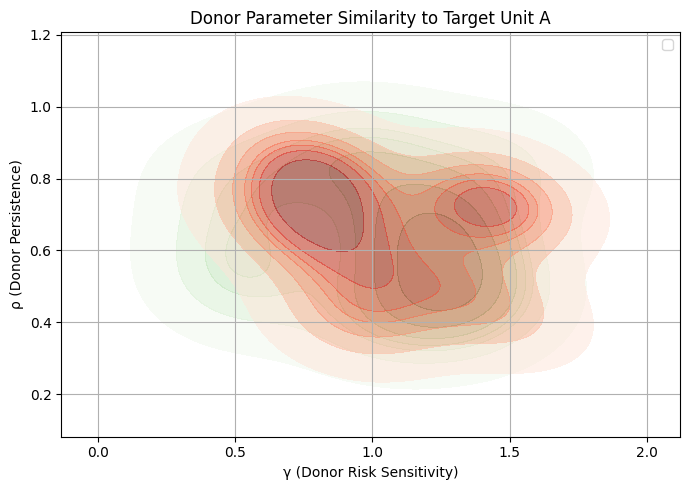

In [29]:
df_param_compare = plot_extreme_donor_similarity(model_dir, data_dir, stage_name=stage_name, figures_dir=figures_dir, save_figures=save_figures)

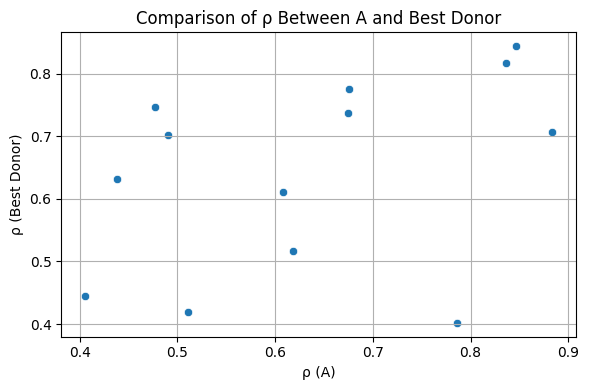

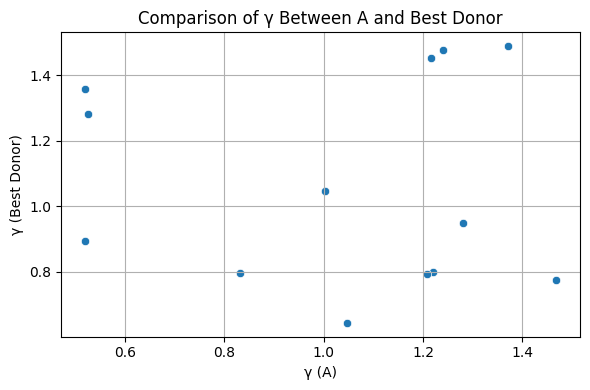

In [30]:
# Scatterplot: ρ comparison
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_param_compare, x="rho_A", y="rho_best")
plt.xlabel("ρ (A)")
plt.ylabel("ρ (Best Donor)")
plt.title("Comparison of ρ Between A and Best Donor")
plt.grid(True)
plt.tight_layout()
plt.show()

# Scatterplot: γ comparison
plt.figure(figsize=(6, 4))
sns.scatterplot(data=df_param_compare, x="gamma_A", y="gamma_best")
plt.xlabel("γ (A)")
plt.ylabel("γ (Best Donor)")
plt.title("Comparison of γ Between A and Best Donor")
plt.grid(True)
plt.tight_layout()
plt.show()

## Unit A's dynamics

In [ ]:
import os
import matplotlib.pyplot as plt
import pandas as pd
from tqdm import tqdm

def plot_unit_A_dynamics(data_dir, sim_range=range(100)):
    y_trajs = []
    x_trajs = []

    for sim_id in tqdm(sim_range, desc="Loading A's data"):
        df_path = os.path.join(data_dir, f"df_sim_{sim_id}.parquet")
        if not os.path.exists(df_path):
            continue

        df = pd.read_parquet(df_path)
        df["year"] = pd.to_datetime(df["year"])
        df_A = df[df["unit"] == "A"].sort_values("year")

        if not df_A.empty:
            y_trajs.append(df_A[["year", "y"]].set_index("year"))
            x_trajs.append(df_A[["year", "x"]].set_index("year"))

    # Combine into single DataFrames
    df_y = pd.concat(y_trajs, axis=1)
    df_y.columns = [f"sim_{i}" for i in range(len(df_y.columns))]

    df_x = pd.concat(x_trajs, axis=1)
    df_x.columns = [f"sim_{i}" for i in range(len(df_x.columns))]

    # Plot Outcome Dynamics
    plt.figure(figsize=(7, 5))
    plt.plot(df_y.index, df_y, alpha=0.3)
    plt.title("Unit A: outcome dynamics across simulations")
    plt.ylabel("y_{At}")
    plt.xlabel("Year")
    plt.grid(True)
    plt.tight_layout()
    if save_figures:
        plt.savefig(os.path.join(figures_dir, f"sim_{stage_name}_outcome_dynamics.pdf"), format="pdf", bbox_inches="tight", dpi=300)
    plt.show()

    # Plot x_{At} Risk Dynamics
    plt.figure(figsize=(7, 5))
    plt.plot(df_x.index, df_x, alpha=0.3, color='tomato')
    plt.title("Unit A: latent risk feature across simulations")
    plt.ylabel("x_{At}")
    plt.xlabel("Year")
    plt.grid(True)
    plt.tight_layout()
    if save_figures:
        plt.savefig(os.path.join(figures_dir, f"sim_{stage_name}_feature_dynamics.pdf"), format="pdf", bbox_inches="tight", dpi=300)
    plt.show()

Loading A's data: 100%|██████████| 100/100 [00:00<00:00, 558.84it/s]


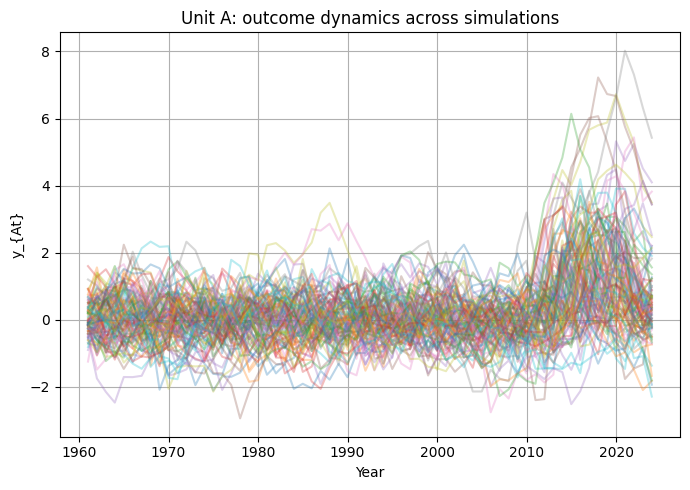

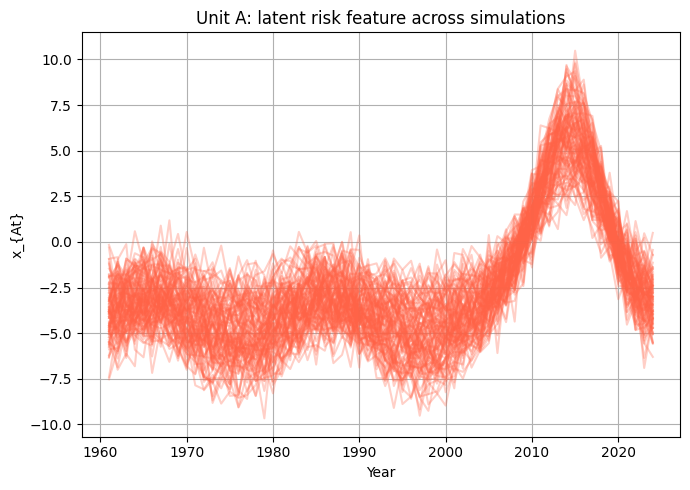

In [ ]:
plot_unit_A_dynamics(data_dir)